In [1]:
import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import dataloader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
class SimCLRModel(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):   # 128是推荐大小，太大可能引入噪声，太小会导致表达能力不足
        super(SimCLRModel, self).__init__()

        # 基础编码器（去掉分类层） <-- 提取输入图像的高位特征表示
        self.encoder = nn.Sequential(*list(base_encoder.children())[:-1])

        # 投影头（带BN的MLP） <-- 整合起来，后续分析中可以直接替换
        self.projection_head = nn.Sequential(
            nn.Linear(512, 512),  # 保持特征表达能力的同时作变换
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, projection_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.projection_head(x)
        return x

In [3]:
class SimCLRLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(SimCLRLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        representations = torch.cat([z_i, z_j], dim=0)  # (2*batch_size, projection_dim)

        similarity_matrix = F.cosine_similarity(
            representations.unsqueeze(1), representations.unsqueeze(0), dim=2
        )  # (2N, 2N)
        # 得到 \tau
        similarity_matrix = similarity_matrix / self.temperature  # 除以温度系数

        # 让z_i与z_j相互找到
        labels_j = torch.arange(batch_size, dtype=torch.long, device=device)
        labels_i = (labels_j + batch_size) % (2 * batch_size)

        # 屏蔽掉对角线（样本自身与自身）
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
        similarity_matrix = similarity_matrix.masked_fill(mask, -np.inf)

        # 计算对比损失
        loss_i = F.cross_entropy(similarity_matrix[:batch_size], labels_i)
        loss_j = F.cross_entropy(similarity_matrix[batch_size:], labels_j)
        loss = (loss_i + loss_j) / 2
        return loss

In [4]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, epochs=20, lr=1e-2, first_step=False):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.lr = lr

        self.optimizer = AdamW(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)
        self.loss_func = SimCLRLoss() if first_step else nn.CrossEntropyLoss()
        self.scaler = torch.amp.GradScaler()
        self.first_step = first_step  # 自监督学习阶段

        self.train_losses, self.val_losses = [], []
        self.train_accs, self.val_accs = [], []
        self.best_accuracy = 0.0
        self.best_loss = float("inf")
        self.epc=1

        self.sf_cnt = 0

    def train(self):
        for epoch in range(self.epochs):
            train_loss, train_acc = self.__train_part()
            val_loss, val_acc = self.__valid_part()
            self.epc += 1

            if not self.first_step:
                if val_acc > self.best_accuracy:
                    self.best_accuracy = val_acc
                    torch.save(self.model.state_dict(), "best_cifar10_model.pth")
                    self.sf_cnt = 0
                else:
                    self.sf_cnt += 1
                    if self.sf_cnt > 5:
                        print("[INFO] Early stopping")
                        break
            elif self.first_step:
                if val_loss < self.best_loss:
                    self.best_loss = val_loss
                    torch.save(self.model.state_dict(), "best_cifar10_model.pth")
                    self.sf_cnt = 0
                else:
                    self.sf_cnt += 1
                    if self.sf_cnt > 5:
                        print("[INFO] Early stopping")
                        break

            print(f"Epoch {epoch + 1}/{self.epochs}")
            print(f"Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.6f} | Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.6f}")

            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            self.scheduler.step()

        return self.train_losses, self.val_losses, self.train_accs, self.val_accs

    def __train_part(self):
        self.model.train()
        total_loss = 0.0
        all_preds, all_labels = [], []
        cc=0
        if self.first_step:
            for views, _ in self.train_loader:
                views = [view.to(self.device) for view in views]
                cc += 1
                with torch.amp.autocast(device_type=self.device.type):
                    z_i, z_j = self.model(views[0]), self.model(views[1])
                    loss = self.loss_func(z_i, z_j)

                self.optimizer.zero_grad()
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                #print(f"[Training] batch/epoch: {cc}/{self.epc} | loss: {loss.item():.6f}")

                total_loss += loss.item()
            return total_loss / len(self.train_loader), 0.0

        for images, labels in self.train_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            cc += 1
            with torch.amp.autocast(device_type=self.device.type):
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)

            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward()
            # 应该不需要梯度裁剪
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            #print(f"[Training] batch/epoch: {cc}/{self.epc} | loss: {loss.item():.6f}")

        train_loss = total_loss / len(self.train_loader)
        train_acc = accuracy_score(all_labels, all_preds)
        return train_loss, train_acc

    def __valid_part(self):
        self.model.eval()
        total_loss = 0.0
        all_preds, all_labels = [], []
        cc = 0
        with torch.no_grad():
            if self.first_step:
                for views, _ in self.val_loader:
                    views = [view.to(self.device) for view in views]
                    cc += 1
                    with torch.amp.autocast(device_type=self.device.type):
                        z_i, z_j = self.model(views[0]), self.model(views[1])
                        loss = self.loss_func(z_i, z_j)

                    total_loss += loss.item()
                    #print(f"[VALIDING] batch/epoch: {cc}/{self.epc} | loss: {loss.item():.6f}")
                return total_loss / len(self.val_loader), 0.0
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                cc += 1
                with torch.amp.autocast(device_type=self.device.type):
                    outputs = self.model(images)
                    loss = self.loss_func(outputs, labels)

                total_loss += loss.item()
                preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())
                #print(f"[VALIDING] batch/epoch: {cc}/{self.epc} | loss: {loss.item():.6f}")

        val_loss = total_loss / len(self.val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        return val_loss, val_acc

### 对比学习（自监督）

In [5]:
train_subset, test_subset = dataloader.load_cifar10_subset(
    "./data", subset_classes=10, train_percent=0.1
)
# 划分验证集
valid_size = int(0.2 * len(train_subset))
train_size = len(train_subset) - valid_size
train_subset, valid_subset = torch.utils.data.random_split(
    train_subset, [train_size, valid_size]
)
train_subset = dataloader.SimCLRDatasetWrapper(train_subset)
valid_subset = dataloader.SimCLRDatasetWrapper(valid_subset)

#train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
#valid_loader = DataLoader(valid_subset, batch_size=128, shuffle=True)
print(f"训练样本数: {len(train_subset)}, 验证样本数: {len(valid_subset)}")

训练样本数: 4000, 验证样本数: 1000


In [15]:
def train_truly(analysis_type, params):
    results = {}
    for param_value in params:
        print(f"Testing: {analysis_type} param: {param_value} ===")

        # 初始化基础编码器    这里加载预训练权重以加速训练过程
        base_encoder = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model = SimCLRModel(base_encoder, projection_dim=128)
        if analysis_type == "projection_head":
            if param_value == "without_bn":
                # 不带 BatchNorm
                model.projection_head = nn.Sequential(
                    nn.Linear(512, 512), nn.ReLU(inplace=True), nn.Linear(512, 128)
                )
            elif param_value == "none":
                model.projection_head = nn.Identity()   # 恒等映射，拿来占位
                model.forward = lambda x: model.encoder(x).view(x.size(0), -1)

        # 数据加载器（对比学习阶段）
        train_loader = DataLoader(
            train_subset,
            batch_size=param_value if analysis_type == "batch_size" else 512,
            shuffle=True,
            num_workers=2
        )
        valid_loader = DataLoader(
            valid_subset,
            batch_size=param_value if analysis_type == "batch_size" else 512,
            shuffle=True,
            num_workers=2
        )
        # 训练器初始化
        trainer = ModelTrainer(
            model=model, train_loader=train_loader, val_loader=valid_loader, epochs=40, lr=1e-3, first_step=True
        )
        if analysis_type == "temperature":
            trainer.loss_func.temperature = param_value  # 动态设置温度系数

        # 训练并记录结果
        train_losses, val_losses, _, _ = trainer.train()
        res_name = f"{analysis_type}_{param_value}"
        results[res_name] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
        }

        if os.path.exists("best_cifar10_model.pth"):
            os.rename("best_cifar10_model.pth", f"{res_name}.pth")
            print(f"[INFO] Model saved as {res_name}.pth")

    return results


def plot_comparison(results, analysis_type, params, title_prefix="strategy"):
    _, axes = plt.subplots(1, 2, figsize=(12, 5))
    train_ax, val_ax = axes

    # 绘制每个参数的训练和验证损失曲线
    for param_value in params:
        res_name = f"{analysis_type}_{param_value}"
        train_losses = results[res_name]["train_losses"]
        val_losses = results[res_name]["val_losses"]

        train_ax.plot(train_losses, label=f"{param_value}")
        val_ax.plot(val_losses, label=f"{param_value}")

    # 设置训练损失子图
    train_ax.set_title(f"{title_prefix} - train loss")
    train_ax.set_xlabel("Epoch")
    train_ax.set_ylabel("Loss")
    train_ax.legend(title="param")
    train_ax.grid(True)

    # 设置验证损失子图
    val_ax.set_title(f"{title_prefix} - valid loss")
    val_ax.set_xlabel("Epoch")
    val_ax.set_ylabel("Loss")
    val_ax.legend(title="param")
    val_ax.grid(True)

    plt.tight_layout()
    plt.show()

### 自动分析

温度系数与自监督对比学习阶段正负样本分布情况有关（具体来说是`softmax`的分布平滑程度），温度系数越小（one-hot），模型对于正负样本的区分就越强，在相同`batch_size`情况下这种区分能力就体现在训练-验证损失上，但可能太关注局部特征而忽略全局特征，泛化能力也会变差（模型对区分太严格了，导致对负样本的学习不够（负样本间的相似性会被放大），这些都会体现在微调情况上）；温度系数增大之后（更平滑）虽然区分能力减弱，但学习到的特征表示更为广泛，泛化能力会有提升

Testing: temperature param: 0.01 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/40
Train Loss: 5.456578, Train Acc: 0.000000 | Val Loss: 4.227163, Val Acc: 0.000000
Epoch 2/40
Train Loss: 3.713610, Train Acc: 0.000000 | Val Loss: 3.464168, Val Acc: 0.000000
Epoch 3/40
Train Loss: 3.169740, Train Acc: 0.000000 | Val Loss: 3.072734, Val Acc: 0.000000
Epoch 4/40
Train Loss: 2.884534, Train Acc: 0.000000 | Val Loss: 2.860430, Val Acc: 0.000000
Epoch 5/40
Train Loss: 2.675055, Train Acc: 0.000000 | Val Loss: 2.658999, Val Acc: 0.000000
Epoch 6/40
Train Loss: 2.544094, Train Acc: 0.000000 | Val Loss: 2.584806, Val Acc: 0.000000
Epoch 7/40
Train Loss: 2.450108, Train Acc: 0.000000 | Val Loss: 2.529983, Val Acc: 0.000000
Epoch 8/40
Train Loss: 2.334420, Train Acc: 0.000000 | Val Loss: 2.482186, Val Acc: 0.000000
Epoch 9/40
Train Loss: 2.292856, Train Acc: 0.000000 | Val Loss: 2.323822, Val Acc: 0.000000
Epoch 10/40
Train Loss: 2.234833, Train Acc: 0.000000 | Val Loss: 2.342789, Val Acc: 0.000000
Epoch 11/40
Train Loss: 2.011830, Train Acc: 0.000000 | Val Loss: 2.0

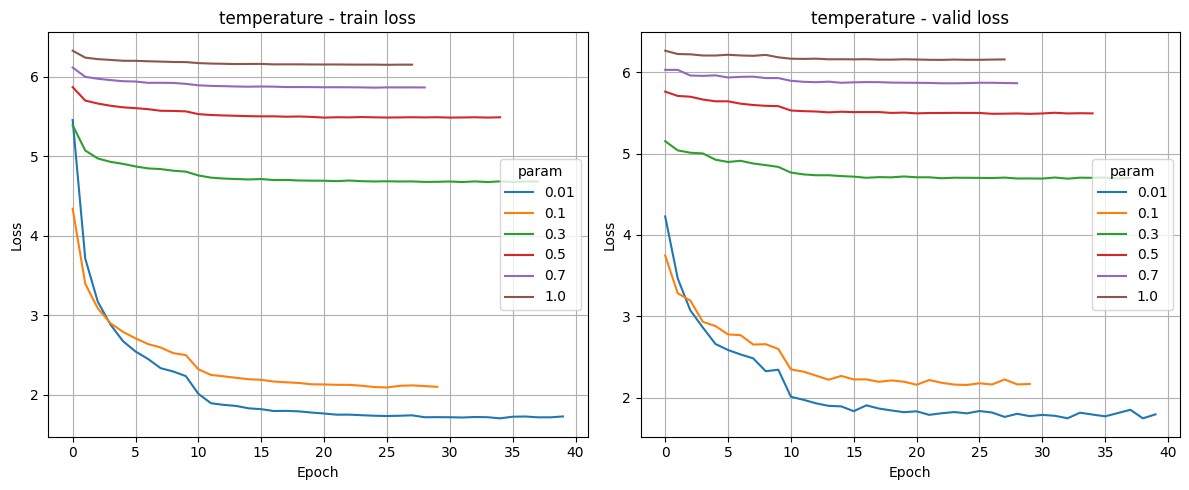

In [7]:
temperatures = [0.01, 0.1, 0.3, 0.5, 0.7, 1.0]
tp_results = train_truly("temperature", temperatures)
plot_comparison(tp_results, "temperature", temperatures, title_prefix="temperature")

`batch_size`与正负样本比例有关（当前一个视图只有一个正样本，增大`batch_size`引入的全部都是负样本），那么小`batch_size`可以让模型更新次数变多，对局部特征的把握能力更好，但是由于负样本很少，对正负样本的区分能力相对会较弱一些；大`batch_size`由于引入了更多的负样本，模型在对比学习过程中区分正负样本的能力会更强一些，但由于样本太多，表现在整体上就会导致损失下降更缓慢

到了微调阶段，小`batch_size`由于在对比学习阶段区分正负样本的能力就不是很足，此时的泛化能力也会受到影响（比如自监督学习阶段可能陷入了局部最优解）；而大`batch_size`虽然区分正负样本的能力更强，但它太依赖于全局特征，对于图像具体细节特征的关注度可能就更弱一些，同样也就影响了微调分类

Testing: batch_size param: 32 ===
Epoch 1/40
Train Loss: 3.440297, Train Acc: 0.000000 | Val Loss: 3.424882, Val Acc: 0.000000
Epoch 2/40
Train Loss: 3.340079, Train Acc: 0.000000 | Val Loss: 3.305889, Val Acc: 0.000000
Epoch 3/40
Train Loss: 3.271634, Train Acc: 0.000000 | Val Loss: 3.251349, Val Acc: 0.000000
Epoch 4/40
Train Loss: 3.234381, Train Acc: 0.000000 | Val Loss: 3.201459, Val Acc: 0.000000
Epoch 5/40
Train Loss: 3.216229, Train Acc: 0.000000 | Val Loss: 3.216838, Val Acc: 0.000000
Epoch 6/40
Train Loss: 3.193816, Train Acc: 0.000000 | Val Loss: 3.237670, Val Acc: 0.000000
Epoch 7/40
Train Loss: 3.169679, Train Acc: 0.000000 | Val Loss: 3.154966, Val Acc: 0.000000
Epoch 8/40
Train Loss: 3.151608, Train Acc: 0.000000 | Val Loss: 3.160836, Val Acc: 0.000000
Epoch 9/40
Train Loss: 3.160721, Train Acc: 0.000000 | Val Loss: 3.187762, Val Acc: 0.000000
Epoch 10/40
Train Loss: 3.146495, Train Acc: 0.000000 | Val Loss: 3.148660, Val Acc: 0.000000
Epoch 11/40
Train Loss: 3.102004, T

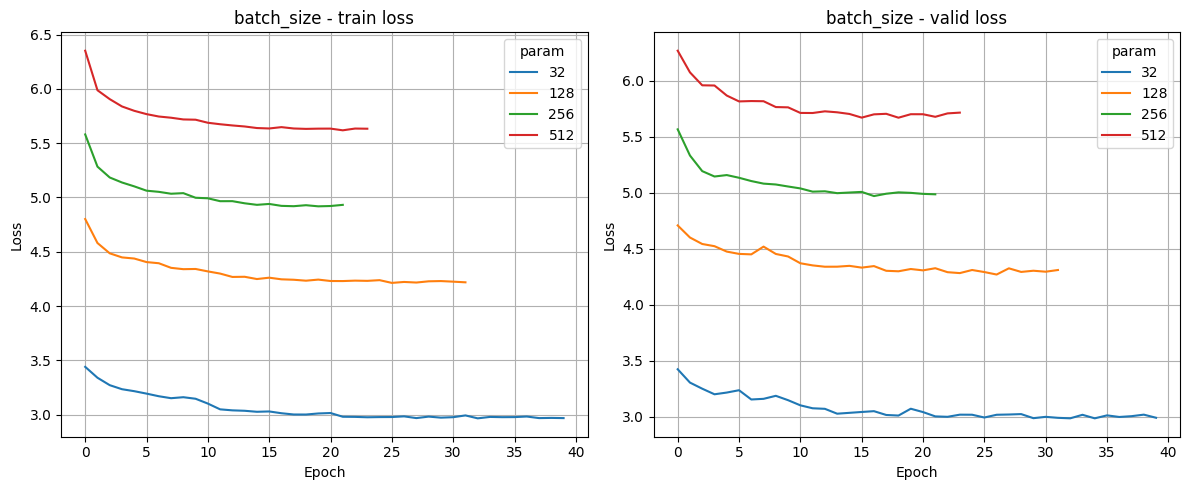

In [13]:
batch_sizes = [32, 128, 256, 512]
bs_results = train_truly("batch_size", batch_sizes)
plot_comparison(bs_results, "batch_size", batch_sizes, title_prefix="batch_size")

Testing: projection_head param: none ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/40
Train Loss: 6.447118, Train Acc: 0.000000 | Val Loss: 6.444196, Val Acc: 0.000000
Epoch 2/40
Train Loss: 6.143178, Train Acc: 0.000000 | Val Loss: 6.193408, Val Acc: 0.000000
Epoch 3/40
Train Loss: 6.060815, Train Acc: 0.000000 | Val Loss: 6.111299, Val Acc: 0.000000
Epoch 4/40
Train Loss: 6.022802, Train Acc: 0.000000 | Val Loss: 6.048721, Val Acc: 0.000000
Epoch 5/40
Train Loss: 5.978681, Train Acc: 0.000000 | Val Loss: 6.078992, Val Acc: 0.000000
Epoch 6/40
Train Loss: 5.962201, Train Acc: 0.000000 | Val Loss: 6.012728, Val Acc: 0.000000
Epoch 7/40
Train Loss: 5.942151, Train Acc: 0.000000 | Val Loss: 5.960878, Val Acc: 0.000000
Epoch 8/40
Train Loss: 5.918444, Train Acc: 0.000000 | Val Loss: 5.970368, Val Acc: 0.000000
Epoch 9/40
Train Loss: 5.918213, Train Acc: 0.000000 | Val Loss: 5.994460, Val Acc: 0.000000
Epoch 10/40
Train Loss: 5.896217, Train Acc: 0.000000 | Val Loss: 5.968056, Val Acc: 0.000000
Epoch 11/40
Train Loss: 5.893985, Train Acc: 0.000000 | Val Loss: 5.9

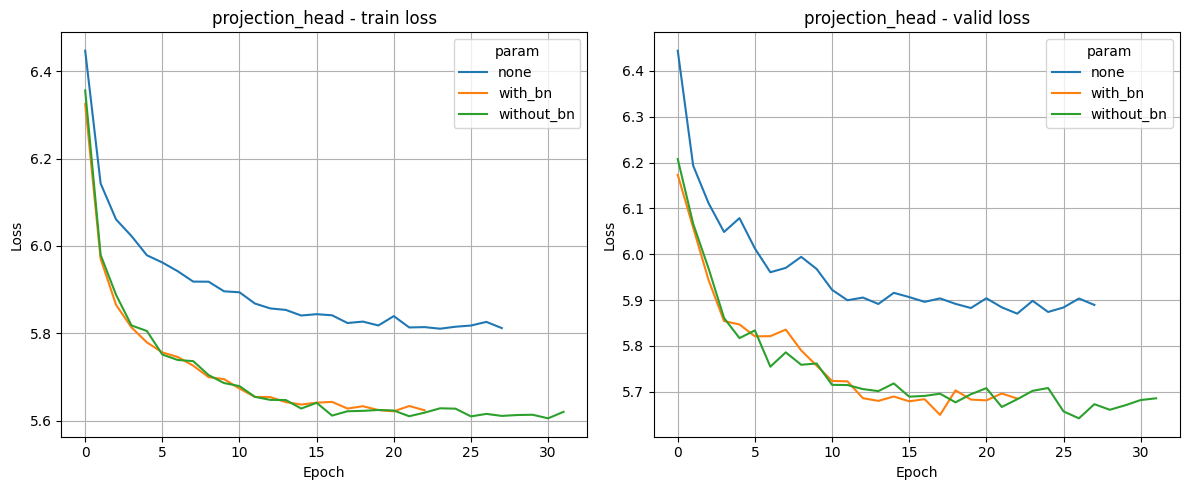

In [7]:
projection_heads = ["none", "with_bn", "without_bn"]
ph_results = train_truly("projection_head", projection_heads)
plot_comparison(ph_results, "projection_head", projection_heads, title_prefix="projection_head")

### 微调

In [20]:
# 使用数据增强
train_transform = dataloader.get_augmentations(normalize=True)  # 获取数据增强操作
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 加载数据集并应用数据增强
train_subset, test_subset = dataloader.load_cifar10_subset(
    "./data", subset_classes=10, train_percent=0.1
)
train_subset.dataset.transform = train_transform  # 为训练集应用数据增强
test_subset.dataset.transform = test_transform    # 为测试集应用标准化

# 划分验证集
valid_size = int(0.2 * len(train_subset))
train_size = len(train_subset) - valid_size
train_subset, valid_subset = torch.utils.data.random_split(
    train_subset, [train_size, valid_size]
)

DL_batch_size = 512
train_loader = DataLoader(train_subset, batch_size=DL_batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_subset, batch_size=DL_batch_size, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=DL_batch_size)

print(
    f"训练样本数: {len(train_subset)}, 验证样本数: {len(valid_subset)}, 测试样本数: {len(test_subset)}"
)

训练样本数: 4000, 验证样本数: 1000, 测试样本数: 10000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
def train_trully(analysis_type, params):
    results = {}
    test_accuracies = []

    for param_value in params:
        print(f"Testing: {analysis_type} param: {param_value} ===")
        model_name = f"{analysis_type}_{param_value}.pth"

        # 加载预训练模型
        base_encoder = models.resnet18(weights=None)
        model = SimCLRModel(base_encoder)

        # 替换投影头为分类头  <-- 这里需要先替换结构再加载模型，不然加载权重时会报错
        model.projection_head = nn.Linear(512, 10)  # 分类头

        # 加载权重时只加载编码器部分
        pretrained_weights = torch.load(model_name, map_location=device)
        model.encoder.load_state_dict(
            {k: v for k, v in pretrained_weights.items() if k.startswith("encoder.")},
            strict=False,
        )

        # 冻结编码器
        for param in model.encoder.parameters():
            param.requires_grad = False

        # 初始化训练器
        trainer = ModelTrainer(
            model=model,
            train_loader=train_loader,
            val_loader=valid_loader,
            epochs=50,
            lr=1e-3,
            first_step=False,
        )

        # 训练并记录结果
        train_losses, val_losses, train_accs, val_accs = trainer.train()
        res_name = f"{analysis_type}_{param_value}"
        results[res_name] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accs": train_accs,
            "val_accs": val_accs,
        }

        # 测试集评估
        test_acc = evaluate_model(
            trainer.model, test_loader, model_path="best_cifar10_model.pth"
        )
        test_accuracies.append(test_acc)

        print(f"[INFO] Test Accuracy for {res_name}: {test_acc:.4f}")

    return results, test_accuracies


def evaluate_model(model, test_loader, model_path="best_cifar10_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # 计算总准确率
    total_accuracy = correct / total
    print(f"Test Accuracy: {total_accuracy:.4f}")

    cr = classification_report(
        all_labels,
        all_preds,
        target_names=[str(i) for i in range(10)],
        output_dict=True,
    )
    for i in range(10):
        print(f"precision for class {dataloader.classes[i]}: {cr[str(i)]['precision']:.4f}")

    # 绘制混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=dataloader.classes,
        yticklabels=dataloader.classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return total_accuracy


def plot_supervised_results(
    results, test_accuracies, analysis_type, params, title_prefix="Supervised Learning"
):
    plot_comparison(
        results, analysis_type, params, title_prefix=f"{title_prefix} - Loss"
    )

    # 绘制训练和验证准确率对比
    _, axes = plt.subplots(1, 2, figsize=(12, 5))
    train_ax, val_ax = axes

    for param_value in params:
        res_name = f"{analysis_type}_{param_value}"
        train_accs = results[res_name]["train_accs"]
        val_accs = results[res_name]["val_accs"]

        train_ax.plot(train_accs, label=f"{param_value}")
        val_ax.plot(val_accs, label=f"{param_value}")

    train_ax.set_title(f"{title_prefix} - Train Accuracy")
    train_ax.set_xlabel("Epoch")
    train_ax.set_ylabel("Accuracy")
    train_ax.legend(title="param")
    train_ax.grid(True)

    val_ax.set_title(f"{title_prefix} - Valid Accuracy")
    val_ax.set_xlabel("Epoch")
    val_ax.set_ylabel("Accuracy")
    val_ax.legend(title="param")
    val_ax.grid(True)

    plt.tight_layout()
    plt.show()

    # 绘制测试集分类正确率折线图
    plt.figure(figsize=(8, 6))
    plt.plot(params, test_accuracies, marker="o", label="Test Accuracy")
    plt.title(f"{title_prefix} - Test Accuracy")
    plt.xlabel("Parameter Value")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

Testing: temperature param: 0.01 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/50
Train Loss: 2.267653, Train Acc: 0.167575 | Val Loss: 2.182774, Val Acc: 0.197200
Epoch 2/50
Train Loss: 2.157383, Train Acc: 0.208350 | Val Loss: 2.143131, Val Acc: 0.215300
Epoch 3/50
Train Loss: 2.130089, Train Acc: 0.220175 | Val Loss: 2.110733, Val Acc: 0.230000
Epoch 4/50
Train Loss: 2.108852, Train Acc: 0.229925 | Val Loss: 2.100639, Val Acc: 0.237000
Epoch 5/50
Train Loss: 2.102719, Train Acc: 0.231900 | Val Loss: 2.105955, Val Acc: 0.222200
Epoch 6/50
Train Loss: 2.099883, Train Acc: 0.233050 | Val Loss: 2.087642, Val Acc: 0.234800
Epoch 7/50
Train Loss: 2.095663, Train Acc: 0.232025 | Val Loss: 2.080170, Val Acc: 0.241000
Epoch 8/50
Train Loss: 2.093725, Train Acc: 0.236950 | Val Loss: 2.086500, Val Acc: 0.240100
Epoch 9/50
Train Loss: 2.092275, Train Acc: 0.236600 | Val Loss: 2.084682, Val Acc: 0.238800
Epoch 10/50
Train Loss: 2.085421, Train Acc: 0.237600 | Val Loss: 2.082945, Val Acc: 0.243600
Epoch 11/50
Train Loss: 2.077041, Train Acc: 0.245500 | Val Loss: 2.0

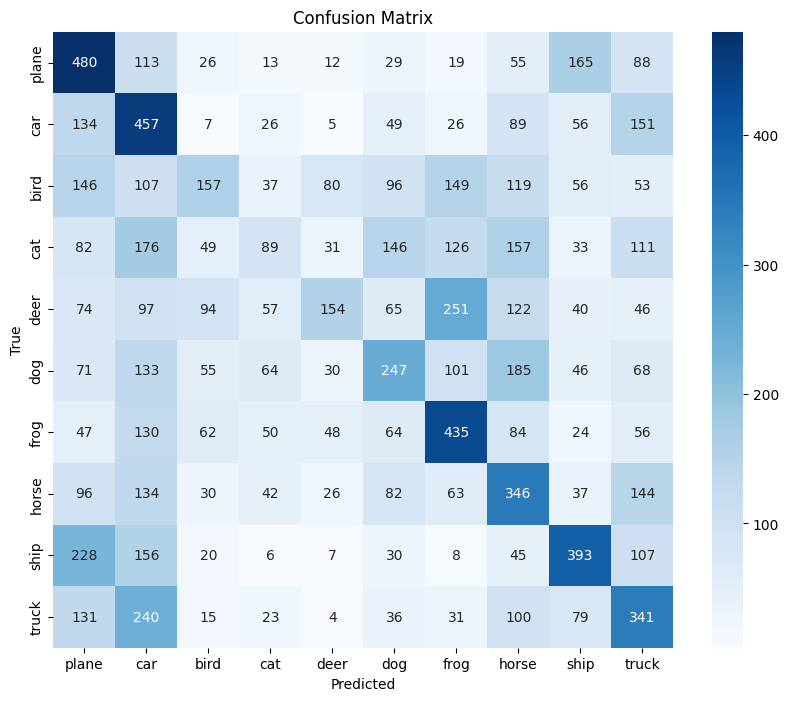

[INFO] Test Accuracy for temperature_0.01: 0.3099
Testing: temperature param: 0.1 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/50
Train Loss: 2.276221, Train Acc: 0.162950 | Val Loss: 2.202344, Val Acc: 0.182800
Epoch 2/50
Train Loss: 2.175340, Train Acc: 0.203250 | Val Loss: 2.155416, Val Acc: 0.208600
Epoch 3/50
Train Loss: 2.137741, Train Acc: 0.215325 | Val Loss: 2.127658, Val Acc: 0.219700
Epoch 4/50
Train Loss: 2.128828, Train Acc: 0.223125 | Val Loss: 2.117363, Val Acc: 0.225500
Epoch 5/50
Train Loss: 2.122809, Train Acc: 0.223900 | Val Loss: 2.116166, Val Acc: 0.222800
Epoch 6/50
Train Loss: 2.118298, Train Acc: 0.224850 | Val Loss: 2.112250, Val Acc: 0.222900
Epoch 7/50
Train Loss: 2.115535, Train Acc: 0.224875 | Val Loss: 2.101244, Val Acc: 0.235900
Epoch 8/50
Train Loss: 2.112692, Train Acc: 0.225125 | Val Loss: 2.120464, Val Acc: 0.228600
Epoch 9/50
Train Loss: 2.114525, Train Acc: 0.232325 | Val Loss: 2.119791, Val Acc: 0.228500
Epoch 10/50
Train Loss: 2.103434, Train Acc: 0.232925 | Val Loss: 2.106824, Val Acc: 0.236800
Epoch 11/50
Train Loss: 2.099416, Train Acc: 0.235900 | Val Loss: 2.0

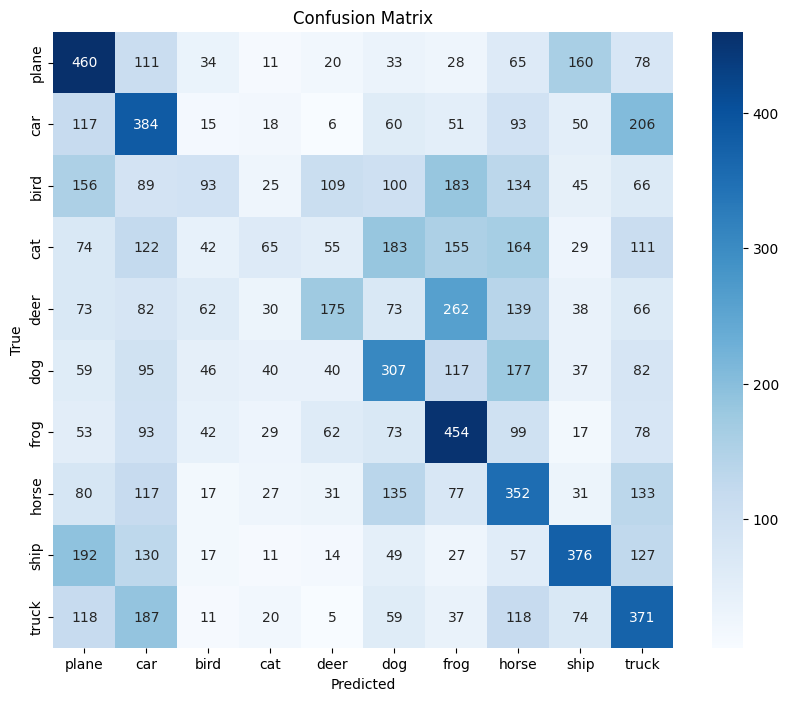

[INFO] Test Accuracy for temperature_0.1: 0.3037
Testing: temperature param: 0.3 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/50
Train Loss: 2.260042, Train Acc: 0.168950 | Val Loss: 2.182169, Val Acc: 0.201100
Epoch 2/50
Train Loss: 2.159884, Train Acc: 0.206300 | Val Loss: 2.127259, Val Acc: 0.220200
Epoch 3/50
Train Loss: 2.124493, Train Acc: 0.222800 | Val Loss: 2.110167, Val Acc: 0.224000
Epoch 4/50
Train Loss: 2.112875, Train Acc: 0.227650 | Val Loss: 2.094493, Val Acc: 0.234100
Epoch 5/50
Train Loss: 2.103646, Train Acc: 0.230675 | Val Loss: 2.109939, Val Acc: 0.230600
Epoch 6/50
Train Loss: 2.095337, Train Acc: 0.234000 | Val Loss: 2.094401, Val Acc: 0.239600
Epoch 7/50
Train Loss: 2.098102, Train Acc: 0.235025 | Val Loss: 2.094124, Val Acc: 0.234100
Epoch 8/50
Train Loss: 2.088629, Train Acc: 0.239475 | Val Loss: 2.081898, Val Acc: 0.239000
Epoch 9/50
Train Loss: 2.087526, Train Acc: 0.235400 | Val Loss: 2.080252, Val Acc: 0.242400
Epoch 10/50
Train Loss: 2.089976, Train Acc: 0.238225 | Val Loss: 2.090986, Val Acc: 0.243900
Epoch 11/50
Train Loss: 2.079895, Train Acc: 0.243450 | Val Loss: 2.0

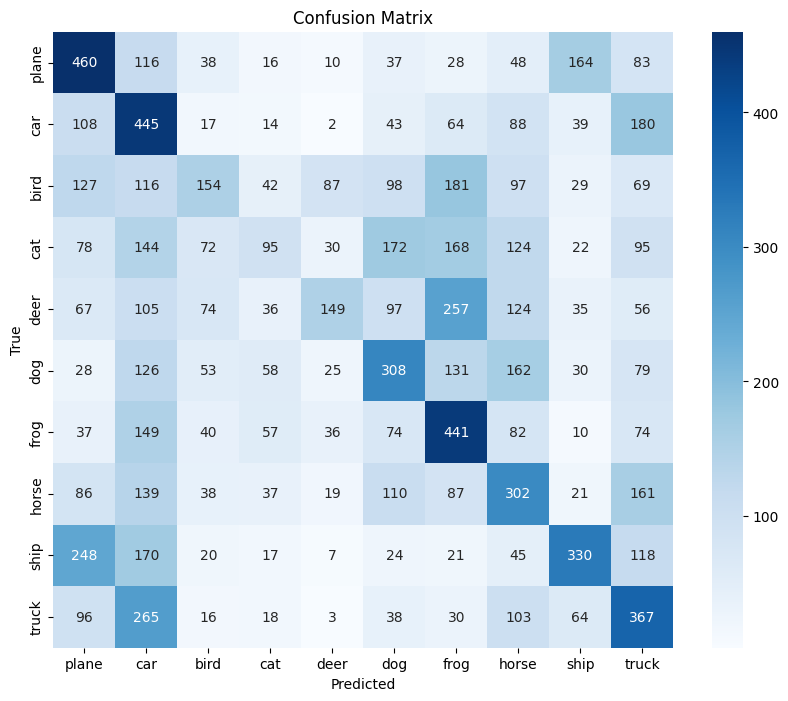

[INFO] Test Accuracy for temperature_0.3: 0.3051
Testing: temperature param: 0.5 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/50
Train Loss: 2.257404, Train Acc: 0.168425 | Val Loss: 2.173656, Val Acc: 0.199600
Epoch 2/50
Train Loss: 2.151722, Train Acc: 0.208875 | Val Loss: 2.125827, Val Acc: 0.217100
Epoch 3/50
Train Loss: 2.127064, Train Acc: 0.222075 | Val Loss: 2.110983, Val Acc: 0.228100
Epoch 4/50
Train Loss: 2.110560, Train Acc: 0.225050 | Val Loss: 2.104054, Val Acc: 0.234800
Epoch 5/50
Train Loss: 2.107202, Train Acc: 0.232425 | Val Loss: 2.106620, Val Acc: 0.226800
Epoch 6/50
Train Loss: 2.093847, Train Acc: 0.235500 | Val Loss: 2.094792, Val Acc: 0.240100
Epoch 7/50
Train Loss: 2.094878, Train Acc: 0.237375 | Val Loss: 2.091965, Val Acc: 0.239300
Epoch 8/50
Train Loss: 2.096200, Train Acc: 0.237825 | Val Loss: 2.092183, Val Acc: 0.244400
Epoch 9/50
Train Loss: 2.099035, Train Acc: 0.235775 | Val Loss: 2.088191, Val Acc: 0.241800
Epoch 10/50
Train Loss: 2.089908, Train Acc: 0.238000 | Val Loss: 2.089470, Val Acc: 0.239700
Epoch 11/50
Train Loss: 2.081662, Train Acc: 0.243075 | Val Loss: 2.0

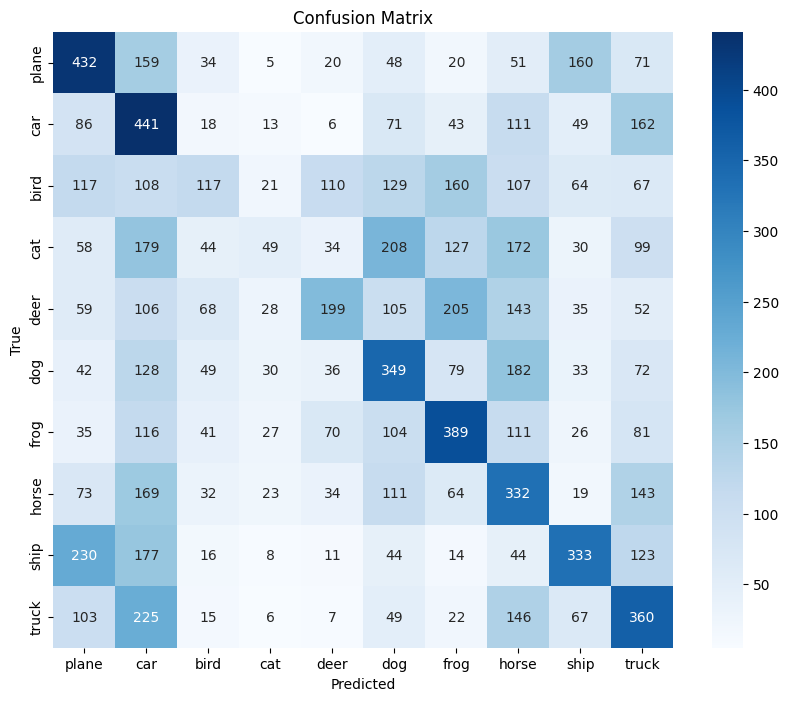

[INFO] Test Accuracy for temperature_0.5: 0.3001
Testing: temperature param: 0.7 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/50
Train Loss: 2.275521, Train Acc: 0.165150 | Val Loss: 2.187327, Val Acc: 0.195000
Epoch 2/50
Train Loss: 2.159968, Train Acc: 0.206975 | Val Loss: 2.145305, Val Acc: 0.210200
Epoch 3/50
Train Loss: 2.128479, Train Acc: 0.218725 | Val Loss: 2.124966, Val Acc: 0.227100
Epoch 4/50
Train Loss: 2.113725, Train Acc: 0.228400 | Val Loss: 2.110624, Val Acc: 0.227200
Epoch 5/50
Train Loss: 2.105581, Train Acc: 0.228150 | Val Loss: 2.098016, Val Acc: 0.233800
Epoch 6/50
Train Loss: 2.095196, Train Acc: 0.234150 | Val Loss: 2.104563, Val Acc: 0.232800
Epoch 7/50
Train Loss: 2.092093, Train Acc: 0.237200 | Val Loss: 2.088083, Val Acc: 0.242700
Epoch 8/50
Train Loss: 2.086730, Train Acc: 0.235825 | Val Loss: 2.094454, Val Acc: 0.240100
Epoch 9/50
Train Loss: 2.089044, Train Acc: 0.236500 | Val Loss: 2.082666, Val Acc: 0.244700
Epoch 10/50
Train Loss: 2.093382, Train Acc: 0.238425 | Val Loss: 2.082670, Val Acc: 0.247500
Epoch 11/50
Train Loss: 2.083267, Train Acc: 0.242700 | Val Loss: 2.0

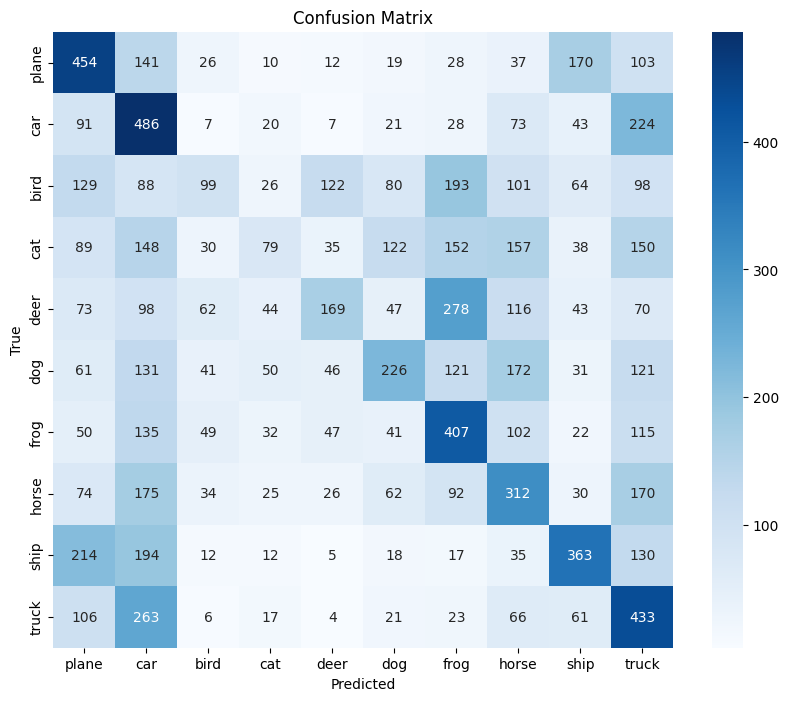

[INFO] Test Accuracy for temperature_0.7: 0.3028
Testing: temperature param: 1.0 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/50
Train Loss: 2.252955, Train Acc: 0.171975 | Val Loss: 2.161221, Val Acc: 0.208600
Epoch 2/50
Train Loss: 2.146046, Train Acc: 0.214800 | Val Loss: 2.131133, Val Acc: 0.215900
Epoch 3/50
Train Loss: 2.119369, Train Acc: 0.222925 | Val Loss: 2.106470, Val Acc: 0.229500
Epoch 4/50
Train Loss: 2.102907, Train Acc: 0.229725 | Val Loss: 2.093487, Val Acc: 0.232600
Epoch 5/50
Train Loss: 2.098155, Train Acc: 0.232400 | Val Loss: 2.093608, Val Acc: 0.238300
Epoch 6/50
Train Loss: 2.092320, Train Acc: 0.237225 | Val Loss: 2.087616, Val Acc: 0.239200
Epoch 7/50
Train Loss: 2.090732, Train Acc: 0.235875 | Val Loss: 2.081343, Val Acc: 0.237800
Epoch 8/50
Train Loss: 2.087171, Train Acc: 0.237375 | Val Loss: 2.080579, Val Acc: 0.240200
Epoch 9/50
Train Loss: 2.082022, Train Acc: 0.239675 | Val Loss: 2.082183, Val Acc: 0.238000
Epoch 10/50
Train Loss: 2.087310, Train Acc: 0.240400 | Val Loss: 2.079148, Val Acc: 0.240800
Epoch 11/50
Train Loss: 2.077943, Train Acc: 0.244800 | Val Loss: 2.0

/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/50
Train Loss: 2.073305, Train Acc: 0.244900 | Val Loss: 2.069888, Val Acc: 0.243000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18/50
Train Loss: 2.065750, Train Acc: 0.245025 | Val Loss: 2.064962, Val Acc: 0.251900


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19/50
Train Loss: 2.070343, Train Acc: 0.247200 | Val Loss: 2.056929, Val Acc: 0.253600


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[INFO] Early stopping
Test Accuracy: 0.3069
precision for class plane: 0.3766
precision for class car: 0.2590
precision for class bird: 0.3174
precision for class cat: 0.2584
precision for class deer: 0.3680
precision for class dog: 0.2796
precision for class frog: 0.3178
precision for class horse: 0.2573
precision for class ship: 0.4343
precision for class truck: 0.2876


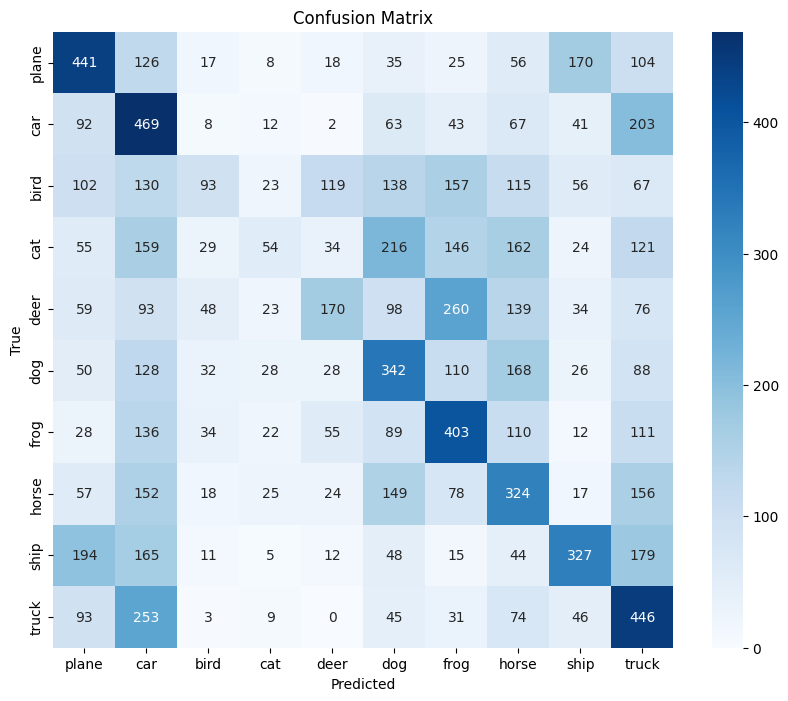

[INFO] Test Accuracy for temperature_1.0: 0.3069


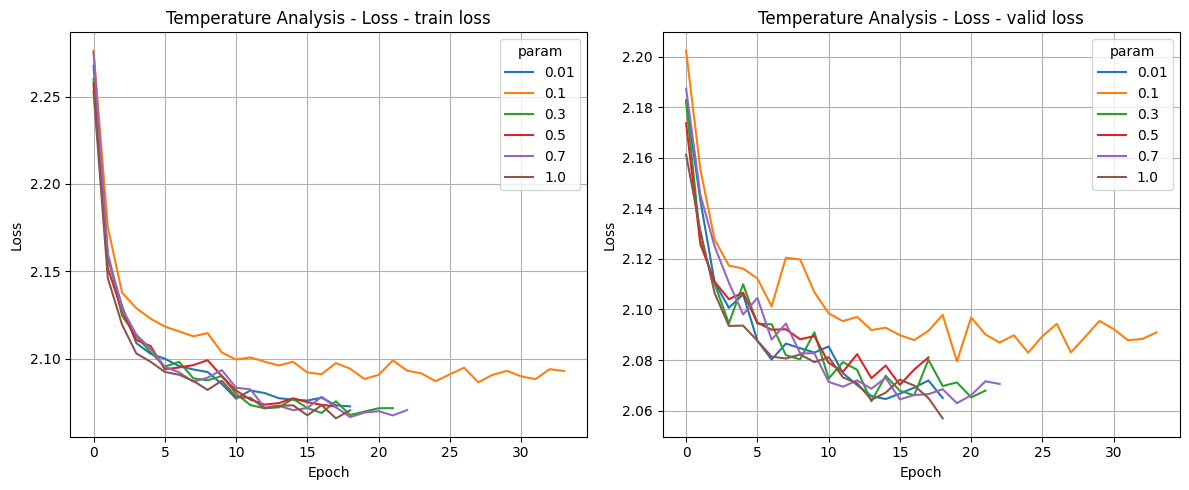

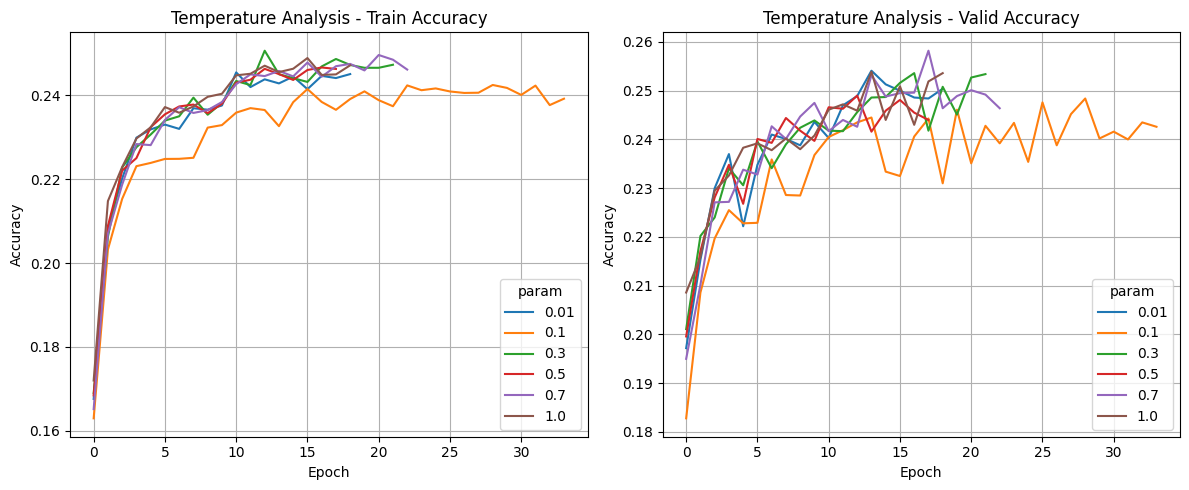

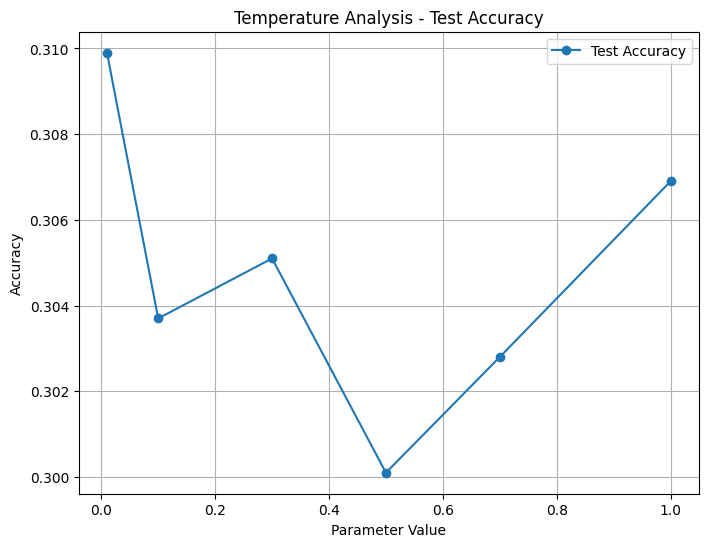

In [19]:
# 定义分析参数
temperatures = [0.01, 0.1, 0.3, 0.5, 0.7, 1.0]

tp_results, tp_test_accuracies = train_trully("temperature", temperatures)

# 绘制结果
plot_supervised_results(
    tp_results,
    tp_test_accuracies,
    "temperature",
    temperatures,
    title_prefix="Temperature Analysis",
)

Testing: batch_size param: 32 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/50
Train Loss: 2.424420, Train Acc: 0.108500 | Val Loss: 2.293440, Val Acc: 0.123000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/50
Train Loss: 2.346865, Train Acc: 0.127250 | Val Loss: 2.311393, Val Acc: 0.111000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/50
Train Loss: 2.308524, Train Acc: 0.158500 | Val Loss: 2.278490, Val Acc: 0.137000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/50
Train Loss: 2.274631, Train Acc: 0.170000 | Val Loss: 2.241783, Val Acc: 0.180000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/50
Train Loss: 2.255153, Train Acc: 0.172250 | Val Loss: 2.215126, Val Acc: 0.189000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/50
Train Loss: 2.221342, Train Acc: 0.179750 | Val Loss: 2.226630, Val Acc: 0.194000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/50
Train Loss: 2.204213, Train Acc: 0.194750 | Val Loss: 2.254529, Val Acc: 0.176000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/50
Train Loss: 2.185030, Train Acc: 0.195000 | Val Loss: 2.226717, Val Acc: 0.174000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/50
Train Loss: 2.190249, Train Acc: 0.196250 | Val Loss: 2.184317, Val Acc: 0.183000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/50
Train Loss: 2.164151, Train Acc: 0.205250 | Val Loss: 2.181781, Val Acc: 0.179000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/50
Train Loss: 2.179324, Train Acc: 0.199000 | Val Loss: 2.174141, Val Acc: 0.188000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[INFO] Early stopping
Test Accuracy: 0.2175
precision for class plane: 0.2557
precision for class car: 0.1877
precision for class bird: 0.1671
precision for class cat: 0.1492
precision for class deer: 0.2551
precision for class dog: 0.2023
precision for class frog: 0.2451
precision for class horse: 0.1655
precision for class ship: 0.2794
precision for class truck: 0.2316


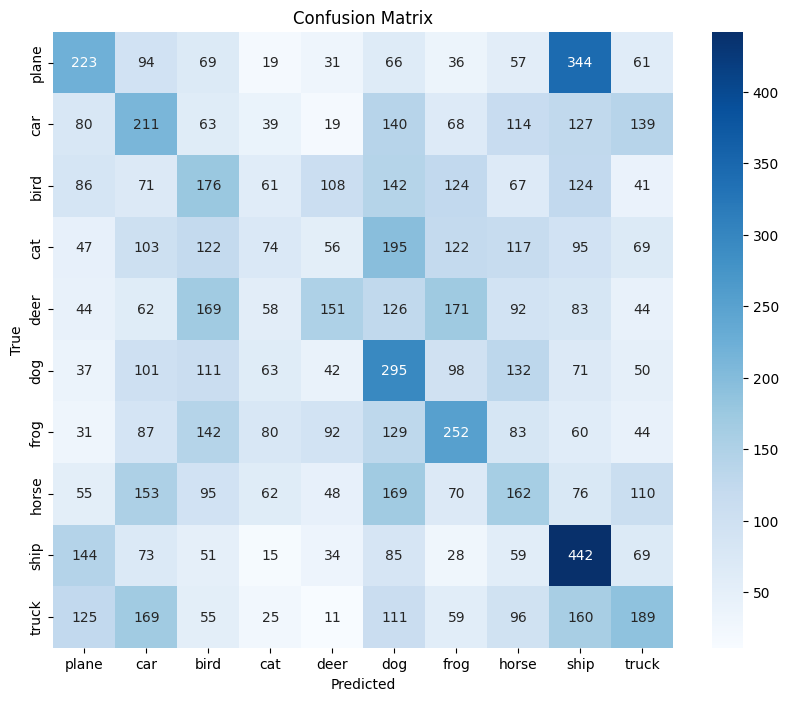

[INFO] Test Accuracy for batch_size_32: 0.2175
Testing: batch_size param: 128 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader runni

Epoch 1/50
Train Loss: 2.425738, Train Acc: 0.109000 | Val Loss: 2.308427, Val Acc: 0.112000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/50
Train Loss: 2.344425, Train Acc: 0.144000 | Val Loss: 2.296533, Val Acc: 0.124000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/50
Train Loss: 2.311145, Train Acc: 0.146750 | Val Loss: 2.282720, Val Acc: 0.148000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/50
Train Loss: 2.260943, Train Acc: 0.168000 | Val Loss: 2.230435, Val Acc: 0.165000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/50
Train Loss: 2.246048, Train Acc: 0.174500 | Val Loss: 2.212589, Val Acc: 0.168000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/50
Train Loss: 2.224070, Train Acc: 0.178000 | Val Loss: 2.190818, Val Acc: 0.188000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/50
Train Loss: 2.185794, Train Acc: 0.192750 | Val Loss: 2.217320, Val Acc: 0.185000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/50
Train Loss: 2.201522, Train Acc: 0.189500 | Val Loss: 2.191732, Val Acc: 0.190000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/50
Train Loss: 2.183519, Train Acc: 0.190250 | Val Loss: 2.199648, Val Acc: 0.187000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/50
Train Loss: 2.173351, Train Acc: 0.198750 | Val Loss: 2.163574, Val Acc: 0.192000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/50
Train Loss: 2.163334, Train Acc: 0.207500 | Val Loss: 2.178388, Val Acc: 0.183000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/50
Train Loss: 2.171708, Train Acc: 0.198750 | Val Loss: 2.166905, Val Acc: 0.190000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/50
Train Loss: 2.149638, Train Acc: 0.206250 | Val Loss: 2.202694, Val Acc: 0.189000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/50
Train Loss: 2.156691, Train Acc: 0.214000 | Val Loss: 2.194035, Val Acc: 0.184000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/50
Train Loss: 2.167207, Train Acc: 0.204500 | Val Loss: 2.196620, Val Acc: 0.195000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/50
Train Loss: 2.150034, Train Acc: 0.213500 | Val Loss: 2.188773, Val Acc: 0.194000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/50
Train Loss: 2.148221, Train Acc: 0.212750 | Val Loss: 2.177848, Val Acc: 0.209000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18/50
Train Loss: 2.156528, Train Acc: 0.211500 | Val Loss: 2.166304, Val Acc: 0.190000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19/50
Train Loss: 2.166306, Train Acc: 0.210000 | Val Loss: 2.204371, Val Acc: 0.188000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20/50
Train Loss: 2.157361, Train Acc: 0.221500 | Val Loss: 2.186580, Val Acc: 0.193000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21/50
Train Loss: 2.142149, Train Acc: 0.217500 | Val Loss: 2.151783, Val Acc: 0.204000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22/50
Train Loss: 2.152499, Train Acc: 0.203500 | Val Loss: 2.172770, Val Acc: 0.192000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[INFO] Early stopping
Test Accuracy: 0.2461
precision for class plane: 0.2933
precision for class car: 0.1997
precision for class bird: 0.2527
precision for class cat: 0.1993
precision for class deer: 0.2992
precision for class dog: 0.2223
precision for class frog: 0.2789
precision for class horse: 0.1933
precision for class ship: 0.3311
precision for class truck: 0.2258


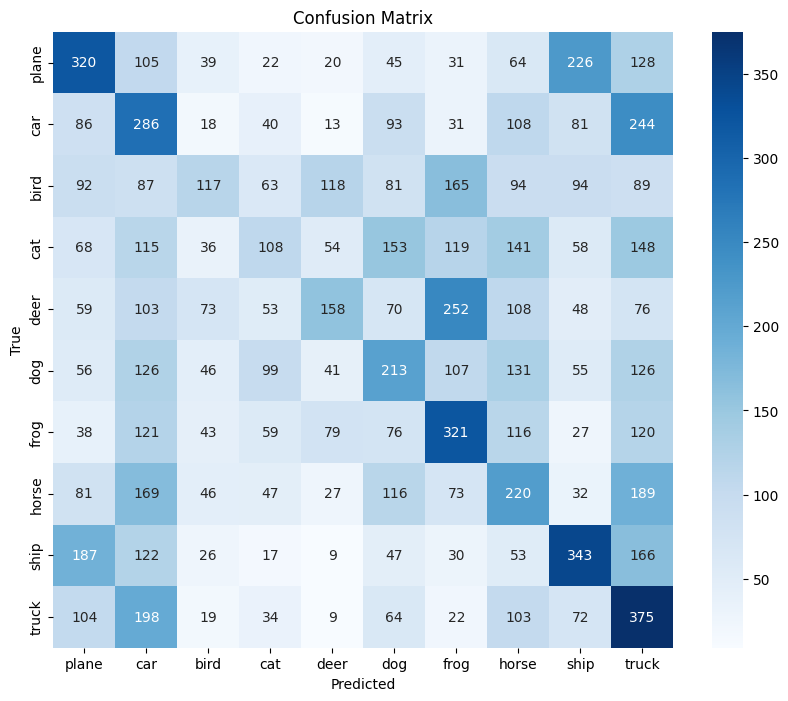

[INFO] Test Accuracy for batch_size_128: 0.2461
Testing: batch_size param: 256 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader runni

Epoch 1/50
Train Loss: 2.394181, Train Acc: 0.125250 | Val Loss: 2.293513, Val Acc: 0.137000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/50
Train Loss: 2.336254, Train Acc: 0.136250 | Val Loss: 2.289076, Val Acc: 0.139000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/50
Train Loss: 2.268814, Train Acc: 0.160250 | Val Loss: 2.264417, Val Acc: 0.150000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/50
Train Loss: 2.246443, Train Acc: 0.174000 | Val Loss: 2.242844, Val Acc: 0.167000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/50
Train Loss: 2.225024, Train Acc: 0.174750 | Val Loss: 2.221883, Val Acc: 0.172000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/50
Train Loss: 2.200844, Train Acc: 0.195750 | Val Loss: 2.215215, Val Acc: 0.183000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/50
Train Loss: 2.205766, Train Acc: 0.189750 | Val Loss: 2.209688, Val Acc: 0.188000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/50
Train Loss: 2.183321, Train Acc: 0.195500 | Val Loss: 2.194600, Val Acc: 0.187000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/50
Train Loss: 2.175851, Train Acc: 0.197750 | Val Loss: 2.169610, Val Acc: 0.201000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/50
Train Loss: 2.157779, Train Acc: 0.204500 | Val Loss: 2.174094, Val Acc: 0.190000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/50
Train Loss: 2.155624, Train Acc: 0.215750 | Val Loss: 2.170103, Val Acc: 0.192000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/50
Train Loss: 2.144288, Train Acc: 0.215750 | Val Loss: 2.182090, Val Acc: 0.190000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/50
Train Loss: 2.153726, Train Acc: 0.206750 | Val Loss: 2.177950, Val Acc: 0.192000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/50
Train Loss: 2.142048, Train Acc: 0.211500 | Val Loss: 2.194509, Val Acc: 0.196000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[INFO] Early stopping
Test Accuracy: 0.2353
precision for class plane: 0.3270
precision for class car: 0.2066
precision for class bird: 0.1624
precision for class cat: 0.1664
precision for class deer: 0.2840
precision for class dog: 0.2137
precision for class frog: 0.2650
precision for class horse: 0.1771
precision for class ship: 0.3538
precision for class truck: 0.2382


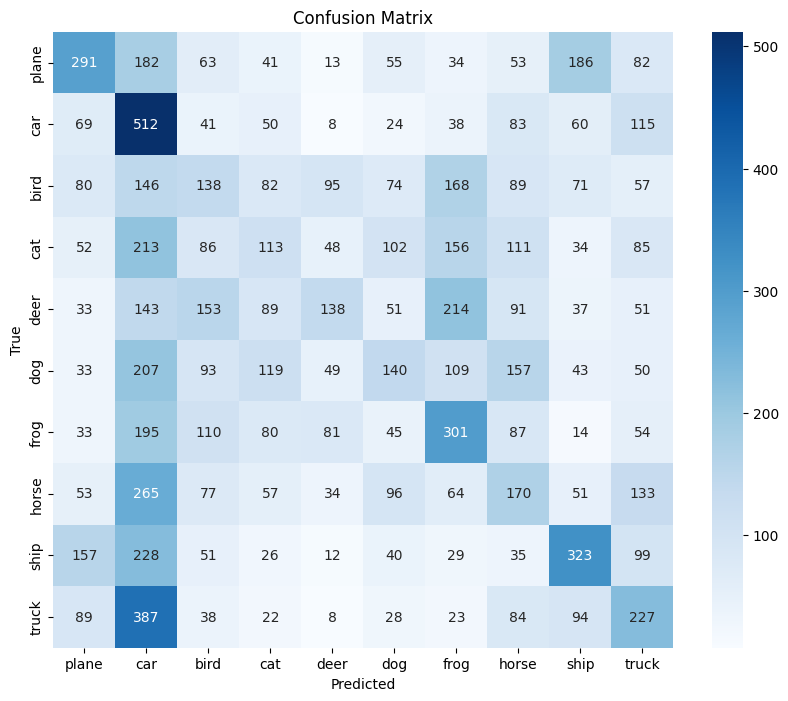

[INFO] Test Accuracy for batch_size_256: 0.2353
Testing: batch_size param: 512 ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader runni

Epoch 1/50
Train Loss: 2.497822, Train Acc: 0.101250 | Val Loss: 2.304357, Val Acc: 0.111000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/50
Train Loss: 2.402785, Train Acc: 0.114500 | Val Loss: 2.302473, Val Acc: 0.116000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/50
Train Loss: 2.339566, Train Acc: 0.133500 | Val Loss: 2.296525, Val Acc: 0.133000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/50
Train Loss: 2.307864, Train Acc: 0.148750 | Val Loss: 2.284275, Val Acc: 0.133000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/50
Train Loss: 2.265778, Train Acc: 0.159000 | Val Loss: 2.267960, Val Acc: 0.159000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/50
Train Loss: 2.237037, Train Acc: 0.176000 | Val Loss: 2.234567, Val Acc: 0.162000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/50
Train Loss: 2.234401, Train Acc: 0.181000 | Val Loss: 2.221942, Val Acc: 0.192000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/50
Train Loss: 2.207785, Train Acc: 0.186500 | Val Loss: 2.217572, Val Acc: 0.180000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/50
Train Loss: 2.210804, Train Acc: 0.190000 | Val Loss: 2.206158, Val Acc: 0.186000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/50
Train Loss: 2.197005, Train Acc: 0.201250 | Val Loss: 2.191076, Val Acc: 0.202000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/50
Train Loss: 2.175896, Train Acc: 0.199750 | Val Loss: 2.182187, Val Acc: 0.203000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/50
Train Loss: 2.177858, Train Acc: 0.202000 | Val Loss: 2.195551, Val Acc: 0.205000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/50
Train Loss: 2.181518, Train Acc: 0.192500 | Val Loss: 2.208184, Val Acc: 0.167000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/50
Train Loss: 2.169791, Train Acc: 0.204000 | Val Loss: 2.185535, Val Acc: 0.200000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/50
Train Loss: 2.173538, Train Acc: 0.203500 | Val Loss: 2.221669, Val Acc: 0.194000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/50
Train Loss: 2.176879, Train Acc: 0.207750 | Val Loss: 2.191398, Val Acc: 0.195000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/50
Train Loss: 2.180868, Train Acc: 0.201000 | Val Loss: 2.169620, Val Acc: 0.185000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[INFO] Early stopping
Test Accuracy: 0.2320
precision for class plane: 0.2910
precision for class car: 0.2078
precision for class bird: 0.2022
precision for class cat: 0.1953
precision for class deer: 0.2505
precision for class dog: 0.2054
precision for class frog: 0.2537
precision for class horse: 0.1834
precision for class ship: 0.2545
precision for class truck: 0.2625


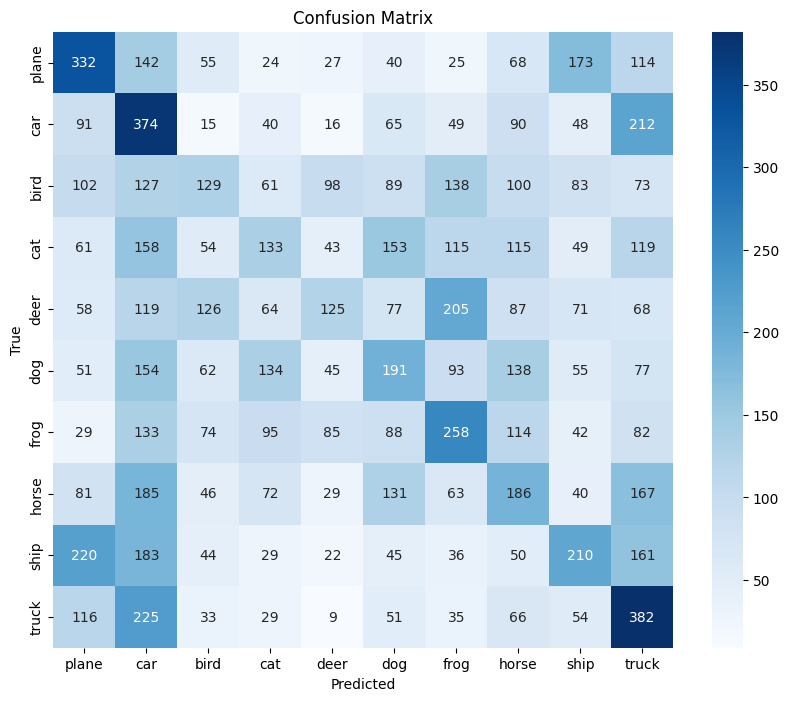

[INFO] Test Accuracy for batch_size_512: 0.2320


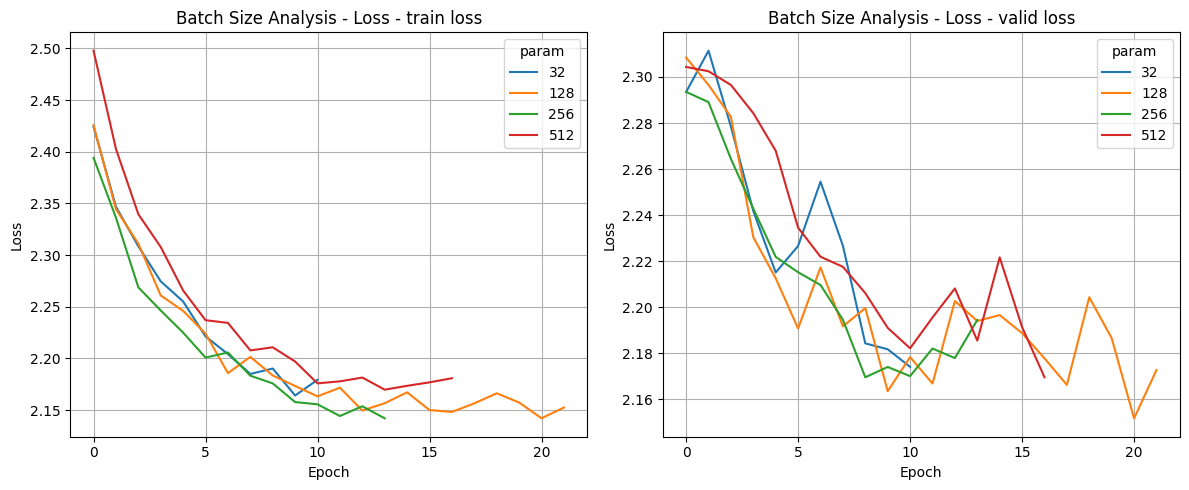

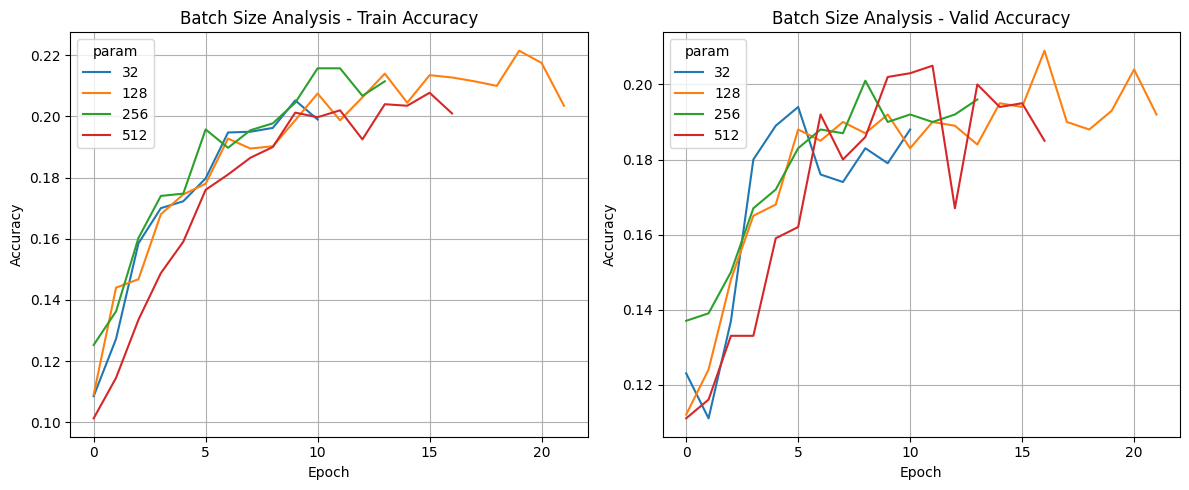

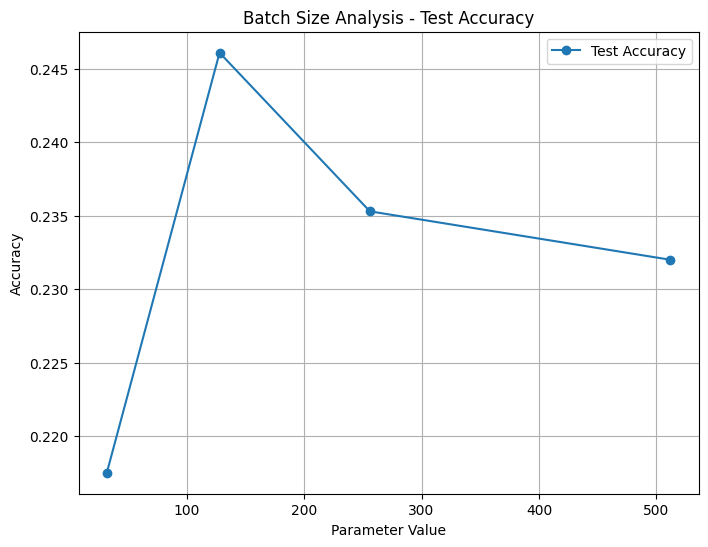

In [21]:
# 定义分析参数
batch_sizes = [32, 128, 256, 512]

# 调用训练函数
bs_results, bs_test_accuracies = train_trully("batch_size", batch_sizes)

# 绘制结果
plot_supervised_results(
    bs_results,
    bs_test_accuracies,
    "batch_size",
    batch_sizes,
    title_prefix="Batch Size Analysis",
)

Testing: projection_head param: none ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader runni

Epoch 1/50
Train Loss: 2.455653, Train Acc: 0.104750 | Val Loss: 2.301845, Val Acc: 0.118000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/50
Train Loss: 2.360182, Train Acc: 0.129750 | Val Loss: 2.295481, Val Acc: 0.134000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/50
Train Loss: 2.301375, Train Acc: 0.156000 | Val Loss: 2.282281, Val Acc: 0.156000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/50
Train Loss: 2.284772, Train Acc: 0.155750 | Val Loss: 2.251561, Val Acc: 0.165000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/50
Train Loss: 2.251039, Train Acc: 0.176000 | Val Loss: 2.232601, Val Acc: 0.186000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/50
Train Loss: 2.236649, Train Acc: 0.180750 | Val Loss: 2.257088, Val Acc: 0.163000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/50
Train Loss: 2.206908, Train Acc: 0.194000 | Val Loss: 2.201851, Val Acc: 0.184000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/50
Train Loss: 2.210298, Train Acc: 0.186500 | Val Loss: 2.197183, Val Acc: 0.211000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/50
Train Loss: 2.191563, Train Acc: 0.190500 | Val Loss: 2.222762, Val Acc: 0.175000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/50
Train Loss: 2.181409, Train Acc: 0.193750 | Val Loss: 2.185451, Val Acc: 0.211000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/50
Train Loss: 2.165794, Train Acc: 0.199250 | Val Loss: 2.210974, Val Acc: 0.170000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/50
Train Loss: 2.161673, Train Acc: 0.198500 | Val Loss: 2.163558, Val Acc: 0.194000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/50
Train Loss: 2.175998, Train Acc: 0.198250 | Val Loss: 2.177548, Val Acc: 0.202000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[INFO] Early stopping
Test Accuracy: 0.2171
precision for class plane: 0.2241
precision for class car: 0.1995
precision for class bird: 0.1979
precision for class cat: 0.1967
precision for class deer: 0.2177
precision for class dog: 0.2109
precision for class frog: 0.2562
precision for class horse: 0.1820
precision for class ship: 0.2759
precision for class truck: 0.2111


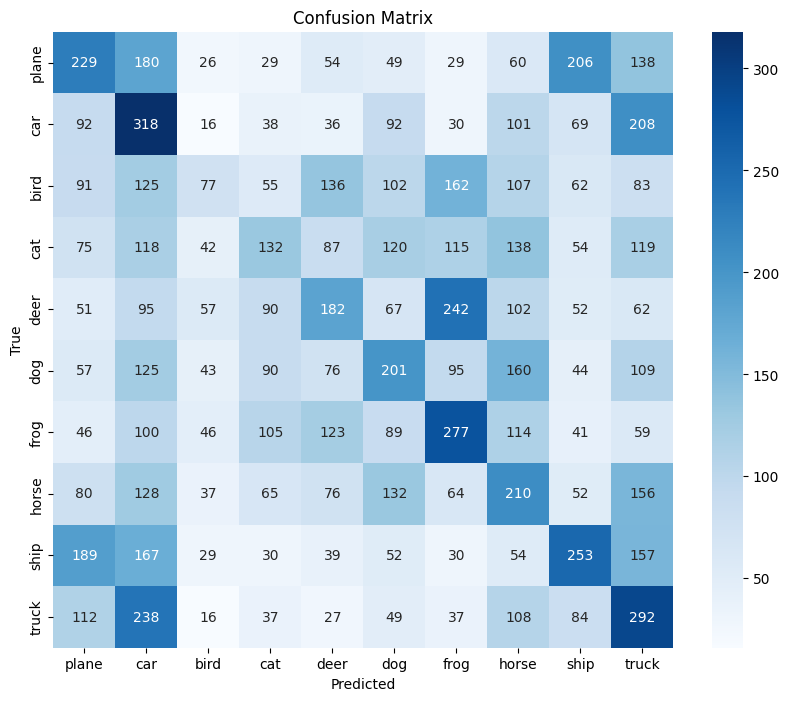

[INFO] Test Accuracy for projection_head_none: 0.2171
Testing: projection_head param: with_bn ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader runni

Epoch 1/50
Train Loss: 2.424578, Train Acc: 0.111000 | Val Loss: 2.292717, Val Acc: 0.119000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/50
Train Loss: 2.348771, Train Acc: 0.130000 | Val Loss: 2.294737, Val Acc: 0.118000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/50
Train Loss: 2.312111, Train Acc: 0.149250 | Val Loss: 2.271821, Val Acc: 0.126000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/50
Train Loss: 2.271711, Train Acc: 0.157000 | Val Loss: 2.261514, Val Acc: 0.142000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/50
Train Loss: 2.244251, Train Acc: 0.168750 | Val Loss: 2.234608, Val Acc: 0.173000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/50
Train Loss: 2.232466, Train Acc: 0.173000 | Val Loss: 2.202644, Val Acc: 0.173000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/50
Train Loss: 2.234855, Train Acc: 0.171750 | Val Loss: 2.217566, Val Acc: 0.189000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/50
Train Loss: 2.193464, Train Acc: 0.191000 | Val Loss: 2.192835, Val Acc: 0.203000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/50
Train Loss: 2.187021, Train Acc: 0.196000 | Val Loss: 2.193480, Val Acc: 0.170000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/50
Train Loss: 2.184724, Train Acc: 0.196750 | Val Loss: 2.200755, Val Acc: 0.182000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/50
Train Loss: 2.176076, Train Acc: 0.199500 | Val Loss: 2.161495, Val Acc: 0.215000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/50
Train Loss: 2.170402, Train Acc: 0.201250 | Val Loss: 2.210251, Val Acc: 0.191000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/50
Train Loss: 2.169628, Train Acc: 0.205250 | Val Loss: 2.205161, Val Acc: 0.181000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/50
Train Loss: 2.162295, Train Acc: 0.204500 | Val Loss: 2.197904, Val Acc: 0.174000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/50
Train Loss: 2.166812, Train Acc: 0.199250 | Val Loss: 2.188010, Val Acc: 0.193000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/50
Train Loss: 2.170007, Train Acc: 0.209000 | Val Loss: 2.160013, Val Acc: 0.209000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[INFO] Early stopping
Test Accuracy: 0.2326
precision for class plane: 0.2991
precision for class car: 0.1985
precision for class bird: 0.1672
precision for class cat: 0.1730
precision for class deer: 0.2813
precision for class dog: 0.1847
precision for class frog: 0.2708
precision for class horse: 0.1844
precision for class ship: 0.3256
precision for class truck: 0.2434


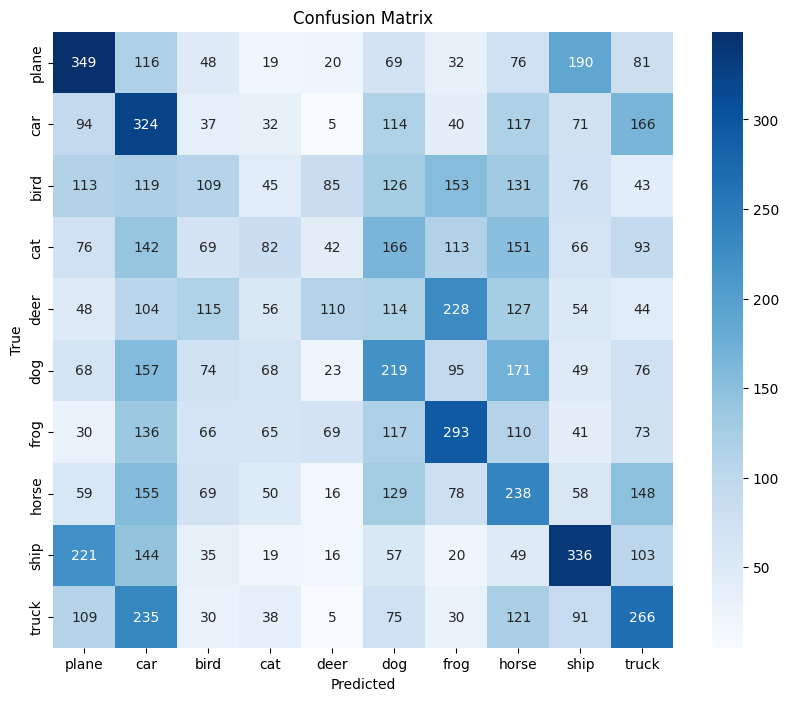

[INFO] Test Accuracy for projection_head_with_bn: 0.2326
Testing: projection_head param: without_bn ===


/home/ubuntu/.local/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader runni

Epoch 1/50
Train Loss: 2.463934, Train Acc: 0.115000 | Val Loss: 2.293289, Val Acc: 0.121000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/50
Train Loss: 2.348541, Train Acc: 0.134250 | Val Loss: 2.314690, Val Acc: 0.115000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/50
Train Loss: 2.301177, Train Acc: 0.161750 | Val Loss: 2.285081, Val Acc: 0.140000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/50
Train Loss: 2.267120, Train Acc: 0.168500 | Val Loss: 2.243631, Val Acc: 0.165000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/50
Train Loss: 2.240658, Train Acc: 0.170000 | Val Loss: 2.234702, Val Acc: 0.156000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/50
Train Loss: 2.231525, Train Acc: 0.179750 | Val Loss: 2.200806, Val Acc: 0.172000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/50
Train Loss: 2.201059, Train Acc: 0.188500 | Val Loss: 2.185643, Val Acc: 0.201000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/50
Train Loss: 2.180964, Train Acc: 0.197000 | Val Loss: 2.166483, Val Acc: 0.184000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/50
Train Loss: 2.167409, Train Acc: 0.195000 | Val Loss: 2.204310, Val Acc: 0.182000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/50
Train Loss: 2.167710, Train Acc: 0.207000 | Val Loss: 2.188861, Val Acc: 0.192000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/50
Train Loss: 2.167376, Train Acc: 0.204750 | Val Loss: 2.189940, Val Acc: 0.206000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/50
Train Loss: 2.171783, Train Acc: 0.199750 | Val Loss: 2.176696, Val Acc: 0.189000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/50
Train Loss: 2.146066, Train Acc: 0.199250 | Val Loss: 2.139518, Val Acc: 0.221000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/50
Train Loss: 2.141527, Train Acc: 0.203000 | Val Loss: 2.201540, Val Acc: 0.167000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/50
Train Loss: 2.149259, Train Acc: 0.209250 | Val Loss: 2.151861, Val Acc: 0.214000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/50
Train Loss: 2.163673, Train Acc: 0.201000 | Val Loss: 2.182622, Val Acc: 0.197000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/50
Train Loss: 2.156345, Train Acc: 0.210000 | Val Loss: 2.170105, Val Acc: 0.196000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18/50
Train Loss: 2.133290, Train Acc: 0.218750 | Val Loss: 2.164453, Val Acc: 0.186000


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[INFO] Early stopping
Test Accuracy: 0.2406
precision for class plane: 0.2619
precision for class car: 0.2033
precision for class bird: 0.2153
precision for class cat: 0.1635
precision for class deer: 0.2849
precision for class dog: 0.2254
precision for class frog: 0.3005
precision for class horse: 0.1949
precision for class ship: 0.3486
precision for class truck: 0.2211


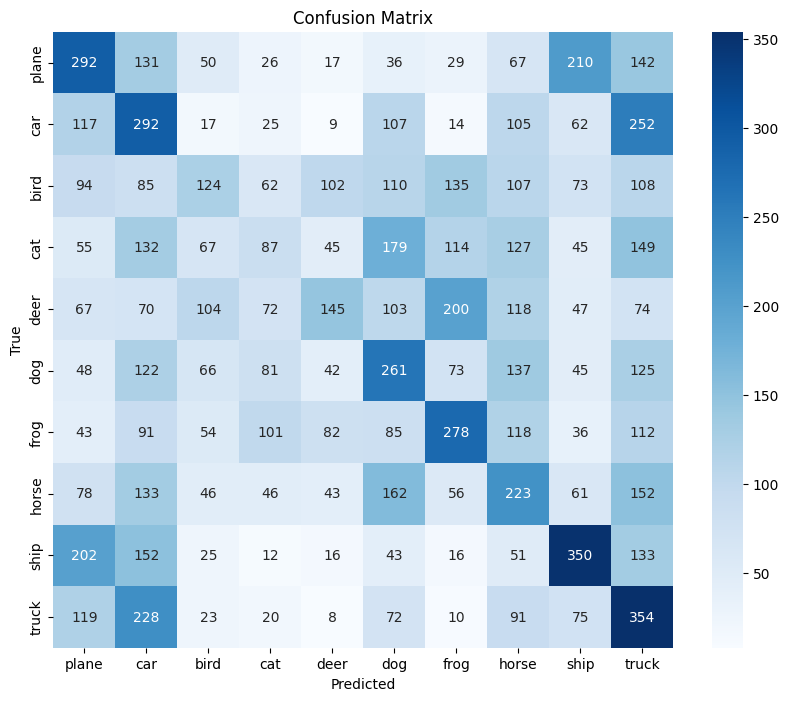

[INFO] Test Accuracy for projection_head_without_bn: 0.2406


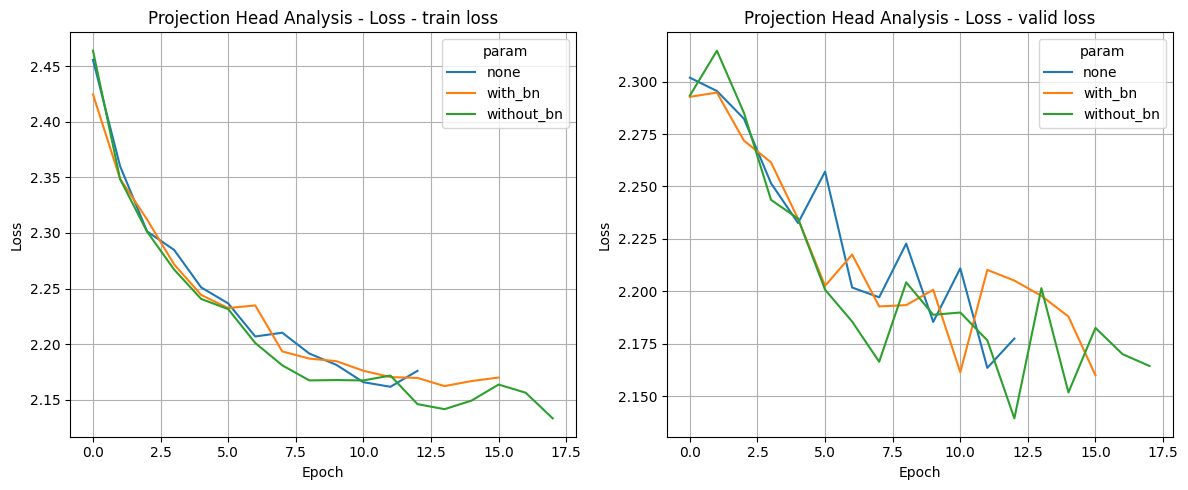

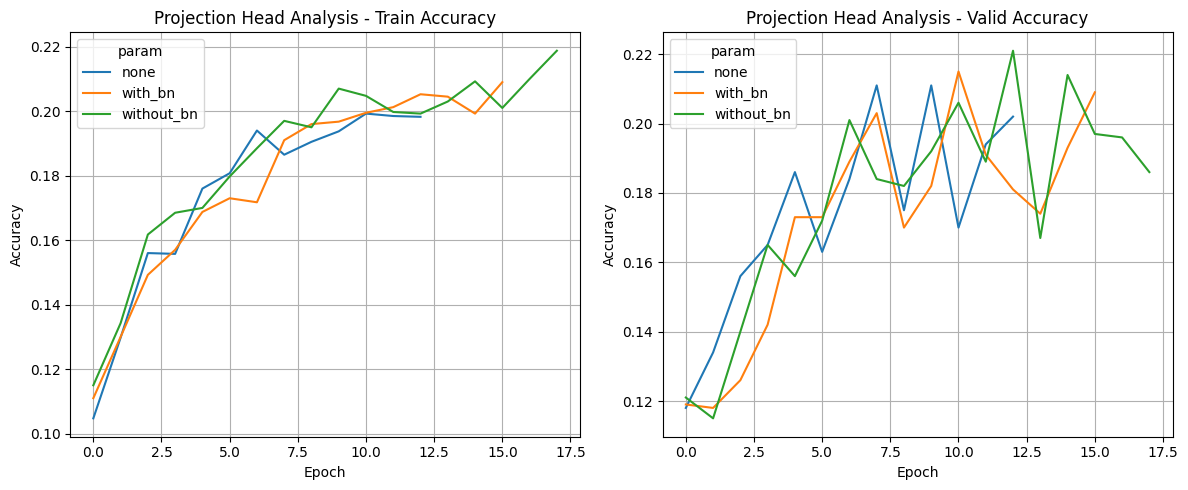

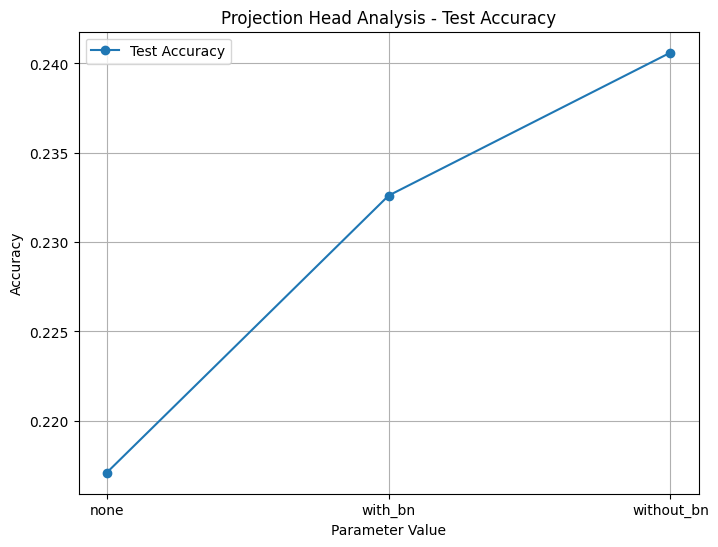

In [22]:
# 定义分析参数
projection_heads = ["none", "with_bn", "without_bn"]

# 调用训练函数
ph_results, ph_test_accuracies = train_trully("projection_head", projection_heads)

# 绘制结果
plot_supervised_results(
    ph_results,
    ph_test_accuracies,
    "projection_head",
    projection_heads,
    title_prefix="Projection Head Analysis",
)